# Swapping Protocol (con diferentes estados Bell)

$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$
$\newcommand{\bra}[1]{\left\langle{#1}\right|}$
$\newcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$

In [1]:
# Importamos algunas cosas necesarias
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit import Qubit
from qiskit import quantum_info
from qiskit.result import marginal_counts
from qiskit import IBMQ, Aer, execute
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex, plot_distribution, plot_state_city
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Función que genera los 4 estados de Bell
def crear_estado_de_bell(circuito, qubits, bell):
    circuito.h(qubits[0])
    circuito.cx(qubits[0], qubits[1])
    match bell:
        case "01":
            circuito.x(qubits[1])
        case "10":
            circuito.z(qubits[1])
        case "11":
            circuito.x(qubits[1])
            circuito.z(qubits[0])
        case "00":
            print("nada")
            
def alice_operaciones(circuito, qubits):
    circuito.cx(qubits[1], qubits[2])
    circuito.h(qubits[1])

def medir_luego_enviar(circuito, qubits, bit1, bit2):
    circuito.measure(qubits[1], bit1)
    circuito.measure(qubits[2], bit2)
    
def bob_operaciones(circuito, qubits, bit1, bit2, bell): 
    circuito.x(qubits[3]).c_if(bit2, not int(bell[1])) #El cbit1 es resultado de medir q0
    circuito.z(qubits[3]).c_if(bit1, not int(bell[0]))#El cbit2 es resultado de medir q1

def swapping(bell_state="00"):
    qubits = QuantumRegister(4, name="q")
    cbit1 = ClassicalRegister(1, name="cbit0") 
    cbit2 = ClassicalRegister(1, name="cbit1") 
    cbit3 = ClassicalRegister(1, name="cbit2") 
    cbit4 = ClassicalRegister(1, name="cbit3")
    circuito = QuantumCircuit(qubits, cbit1, cbit2, cbit3, cbit4)
    
    #Inicializamos pares entrelazados:
    crear_estado_de_bell(circuito, [qubits[0], qubits[1]], bell_state)
    crear_estado_de_bell(circuito, [qubits[2], qubits[3]], bell_state)
    circuito.barrier()
    
    #Alice realiza operaciones con sus qubits
    alice_operaciones(circuito, qubits)
    
    ####
    #Alice mide sus qúbits y envía por whatsapp a Bob
    medir_luego_enviar(circuito, qubits, cbit2, cbit3)
    circuito.barrier()
    
    #Bob recibe bits de Alice y efectúa algunas operaciones
    bob_operaciones(circuito, qubits, cbit2, cbit3, bell_state)
 
    
    circuito.cx(qubits[0], qubits[3])
    circuito.h(qubits[0])
   
    circuito.measure(qubits[0], cbit1)
    circuito.measure(qubits[3], cbit4)

    return [circuito, qubits]

# Función de Swapping

El parámetro **bell_state** recibe como argumento el estado de Bell deseado ("00", "01", "10", "11") de acuerdo a lo siguiente:

<img src="img/estados_bell.png">

Tomemos como ejemplo **bell_state="11"**:

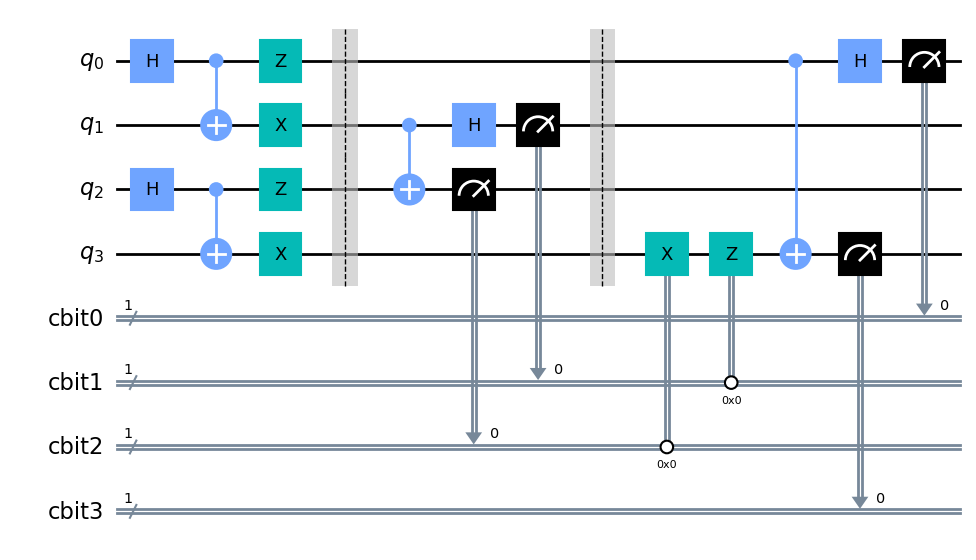

In [3]:
qc, qubits = swapping("11")
qc.draw(output="mpl")

# Ejecución del circuito

In [4]:
import numpy as np
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Create an empty noise model
noise_model = NoiseModel()

# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.001, 1)
noise_model.add_all_qubit_quantum_error(error, ['u1', 'u2', 'u3'])

# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u1', 'u3', 'u2']
  All-qubits errors: ['u1', 'u2', 'u3']


In [5]:
sim = AerSimulator(noise_model=noise_model)
output = execute(qc, sim).result()
counts = output.get_counts(qc)

> Es importante recordar que counts almacena los resultados de las medidas de cada registro clásico correspondiente al qúbit que se ha medido. Ejemplo: si mido el qúbit en la posición 0, y lo guardo en el bit clásico en la posición 3, entonces la información de medida de mi qúbit ahora estará siempre en la posición 3. **Es importante almacenar resultados de qúbits en bits en la misma posición para evitar confusión.**

In [6]:
qubit_counts = [marginal_counts(counts, [bit]) for bit in range(4)]

Text(0.5, 0, 'Estados Clásicos')

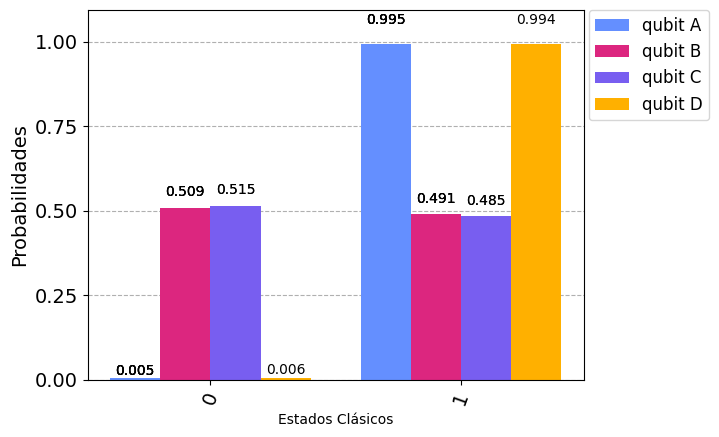

In [9]:
grafica = plt.subplot()
legendas = ["qubit A","qubit B","qubit C","qubit D"]
plot_distribution(qubit_counts, ax=grafica, legend=legendas)
grafica.set_ylabel('Probabilidades')
grafica.set_xlabel('Estados Clásicos')

> Debido al disentangler al final del circuito swapping, se aprecia que el estado de Bell resultante entre las partículas de los extremos A y D se mapean al estado 
$\ket{11}$ por ende se debe obtener el 100% de las veces dicho estado.

In [8]:
def first_qubit_state(circuit, qubits):
    """Get the statevector for the first qubit, discarding the rest."""
    # get the full statevector of all qubits
    full_statevector = quantum_info.Statevector.from_instruction(circuit)

    # get the density matrix for the first qubit by taking the partial trace
    partial_density_matrix = quantum_info.partial_trace(full_statevector, qubits)

    # extract the statevector out of the density matrix
    partial_statevector = np.diagonal(partial_density_matrix)
    vector = quantum_info.Statevector(partial_statevector)
    return vector